# Problem Statement

An airline company has passengers data across different months. We need to build a forecast to determine how many number of passenges are going to abort these airlines at the month level in the future.  

# Work Flow

1. Data Collection -> Using Airline passengers data having dates from 1949 till 1960 & number of passengers travelling per month
2. Stationarity check -> by 2 methods rolling statistics & ADCF
3. if data is not stationary -> Making a non-stationary time-series stationary
4. Plotting ACF & PACF -> for determining P & Q values
5. Time Series Models -> AR, MA, ARIMA
6. Predictions -> predicting the number of passengers for the next ten years 

In [3]:
# importing the required libraries

import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=10,6
import warnings
warnings.filterwarnings('ignore')

# Data Collection

In [4]:
data = pd.read_excel('Airline_Passengers_data.xlsx')

# parse strings to datetime type
data['Month'] = pd.to_datetime(data['Month'], infer_datetime_format=True)

# makingb the month as index column
data = data.set_index(['Month'])
data.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


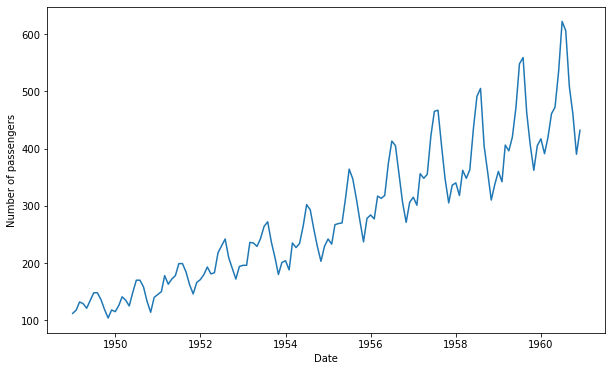

In [5]:
# plotting the data
plt.xlabel('Date')
plt.ylabel('Number of passengers')
plt.plot(data)

From the plot we can see that there is an upward trend. Hence, we’ll go for stationarity check.

# Stationarity Check

# a.Rolling Statistics

In [6]:
# Determining rolling statistics
rolmean = data.rolling(window=12).mean()     # window size 12 denotes 12 months, giving rolling mean at yearly level
rolstd = data.rolling(window=12).std()
print(rolmean,rolstd)

            Passengers
Month                 
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
...                ...
1960-08-01  463.333333
1960-09-01  467.083333
1960-10-01  471.583333
1960-11-01  473.916667
1960-12-01  476.166667

[144 rows x 1 columns]             Passengers
Month                 
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
...                ...
1960-08-01   83.630500
1960-09-01   84.617276
1960-10-01   82.541954
1960-11-01   79.502382
1960-12-01   77.737125

[144 rows x 1 columns]


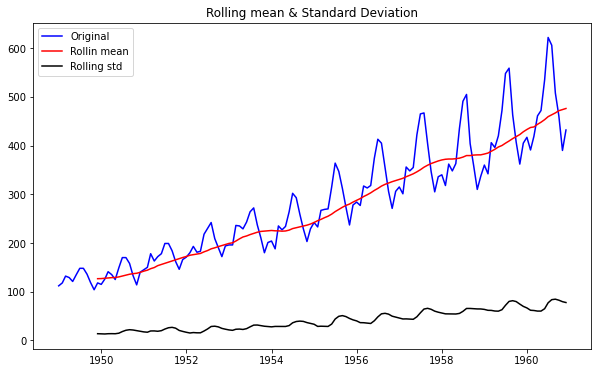

In [7]:
# plotting rolling statistics:
original = plt.plot(data, color='blue',label='Original')
mean = plt.plot(rolmean, color = 'red', label = 'Rollin mean')
std = plt.plot(rolstd, color = 'black', label = 'Rolling std')
plt.legend(loc='best')
plt.title('Rolling mean & Standard Deviation')
plt.show(block=False)

In the above plot we can see the upward trend in the mean, while standard deviation is constant with time.

For the series to be stationary, both the mean and standard deviation have to be constant with time, i.e. parallel to x-axis.

# b.ADCF Test 

ADCF Test — Augmented Dickey–Fuller test is used to gives us various values that can help in identifying stationarity. The Null hypothesis says that a Time-series is non-stationary. It comprises of a Test Statistics & some critical values for some confidence levels. If the Test statistics is less than the critical values, we can reject the null hypothesis & say that the series is stationary. The ADCF test also gives us a p-value. According to the null hypothesis, lower values of p is better.

In [8]:
# performing Augmented Dickey-Fuller test:

print('Results of Dickey-Fuller Test:')
test = adfuller(data['Passengers'], autolag = 'AIC')

output = pd.Series(test[0:4], index=['Test Statisic','p-value','#Lags used','Number of Observations used'])
for key,value in test[4].items():
    output['Critical value (%s)'%key] = value
    
print(output)

Results of Dickey-Fuller Test:
Test Statisic                    0.815369
p-value                          0.991880
#Lags used                      13.000000
Number of Observations used    130.000000
Critical value (1%)             -3.481682
Critical value (5%)             -2.884042
Critical value (10%)            -2.578770
dtype: float64


From the result shown in ADCF test, we can see here that p-value >0.05 and also Test Statistics is not less than any of the critical value. Hence, we fail to reject the null hypothesis and therefore the series is non-stationary.

# Making a non-stationary time-series stationary

# 1.Differencing

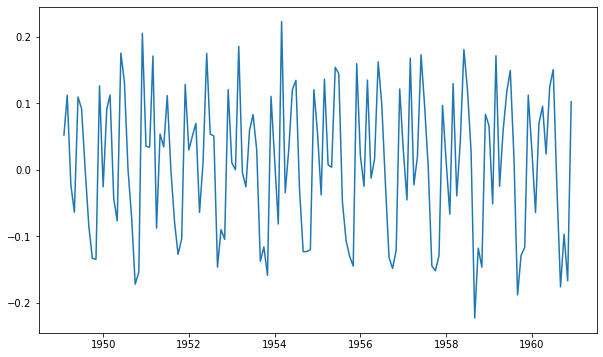

In [9]:
# Using time shift (or Differencing) method for stationarity
data_logscale = np.log(data)
data_log_shifting = data_logscale - data_logscale.shift(1)
plt.plot(data_log_shifting)

In [10]:
# defining the function for repeated use rather than writing whole code every time
def test_stationary(timeseries):
    
    # Determining rolling statitics
    moving_avg = timeseries.rolling(window=12).mean()
    moving_std = timeseries.rolling(window=12).std()
    
    # plot rolling statistics:
    original = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(moving_avg, color = 'red', label = 'Rollin mean')
    std = plt.plot(moving_std, color = 'black', label = 'Rolling std')
    plt.legend(loc='best')
    plt.title('Rolling mean & Standard Deviation')
    plt.show(block=False)
    
    # performing Augmented Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    test = adfuller(timeseries['Passengers'], autolag = 'AIC')
    output = pd.Series(test[0:4], index=['Test Statisic','p-value','#Lags used','Number of Observations used'])
    for key,value in test[4].items():
        output['Critical value (%s)'%key] = value
    print(output)

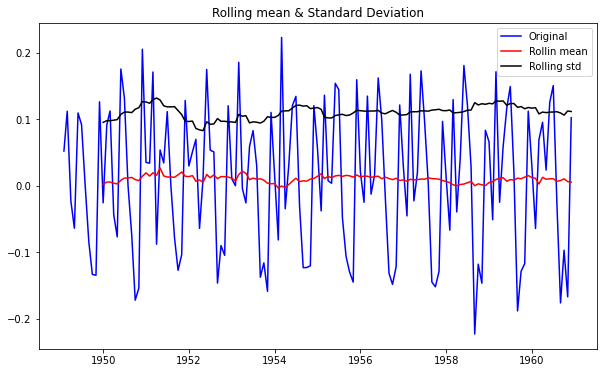

Results of Dickey-Fuller Test:
Test Statisic                   -2.717131
p-value                          0.071121
#Lags used                      14.000000
Number of Observations used    128.000000
Critical value (1%)             -3.482501
Critical value (5%)             -2.884398
Critical value (10%)            -2.578960
dtype: float64


In [11]:
data_log_shifting.dropna(inplace=True)
test_stationary(data_log_shifting)

Here, our p-value is 0.07 which is  close to 0.05 and Test Statistics value lies in between the Critical value (10%) and Critical Value (5%) and also Rolling Mean and Rolling Standard deviation is constant with time.

The result will be better if we use Exponential Decay method.

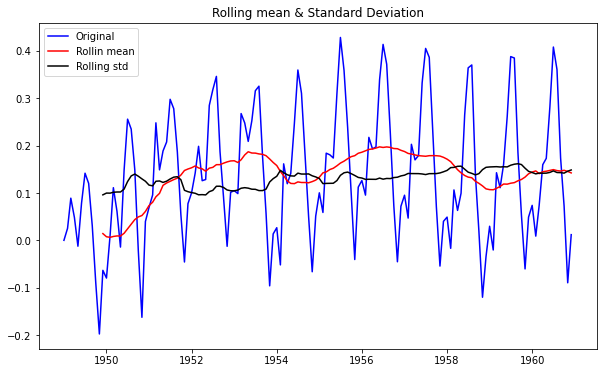

Results of Dickey-Fuller Test:
Test Statisic                   -3.601262
p-value                          0.005737
#Lags used                      13.000000
Number of Observations used    130.000000
Critical value (1%)             -3.481682
Critical value (5%)             -2.884042
Critical value (10%)            -2.578770
dtype: float64


In [12]:
exp_Decaying_weighted_Avg = data_logscale.ewm(halflife=12, min_periods=0, adjust=True).mean()
logscale_exp_avg = data_logscale - exp_Decaying_weighted_Avg
test_stationary(logscale_exp_avg)

# 2.Decomposition of time-series

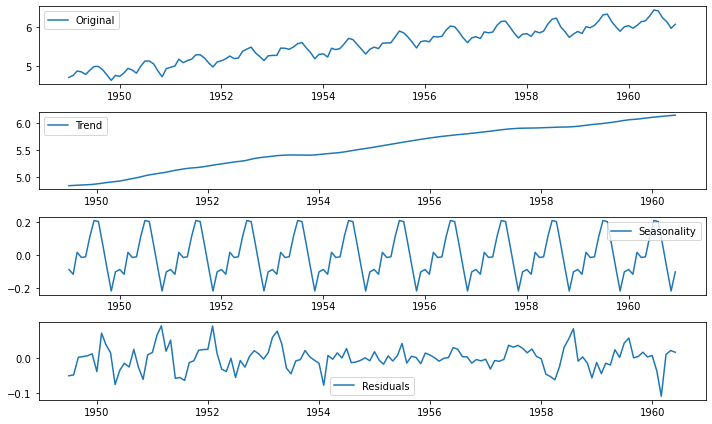

In [13]:
decomposition = seasonal_decompose(data_logscale)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(data_logscale, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

# Plotting ACF & PACF

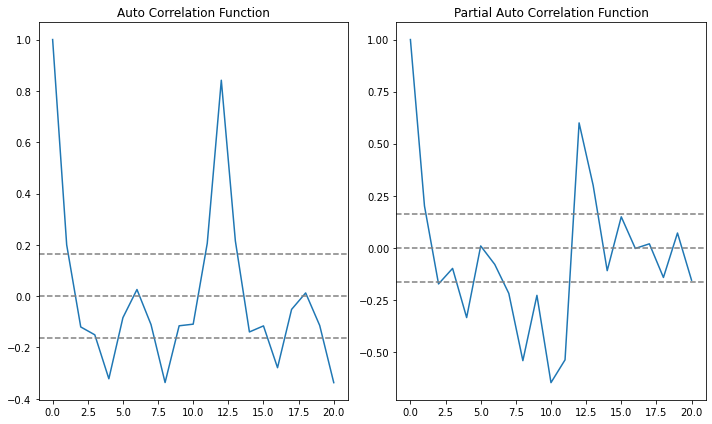

In [14]:
lag_acf = acf(data_log_shifting, nlags=20)
lag_pacf = pacf(data_log_shifting, nlags=20, method='ols')

# plot acf
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_log_shifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_log_shifting)), linestyle='--', color='gray')
plt.title('Auto Correlation Function')

# plot pacf
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_log_shifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_log_shifting)), linestyle='--', color='gray')
plt.title('Partial Auto Correlation Function')

plt.tight_layout()

From the ACF graph, we see that curve touches y=0.0 line at x=2. Thus, from theory, Q = 2 

From the PACF graph, we see that curve touches y=0.0 line at x=2. Thus, from theory, P = 2.

# Time-Series Model

# 1.Auto-Regressive (AR) model

AR Model


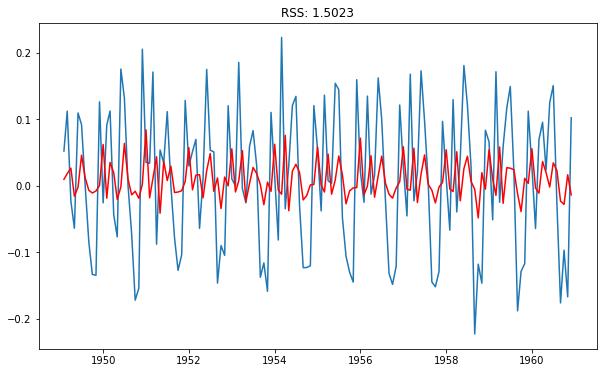

In [15]:
AR_model = ARIMA(data_logscale, order=(2,1,0))
results_AR = AR_model.fit(disp=-1)
plt.plot(data_log_shifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f' %sum((results_AR.fittedvalues - data_log_shifting.Passengers)**2))
print('AR Model')

# 2.Moving Average (MA) Model

MA Model


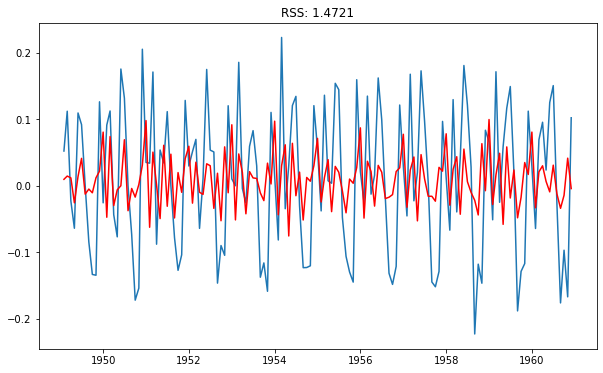

In [16]:
MA_model = ARIMA(data_logscale, order=(0,1,2))
results_MA = MA_model.fit(disp=-1)
plt.plot(data_log_shifting)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f' %sum((results_MA.fittedvalues - data_log_shifting.Passengers)**2))
print('MA Model')

# 3.ARIMA Model

ARIMA (Auto Regressive Integrated Moving Average) is a combination of both models AR (Auto Regressive) & MA (Moving Average).

ARIMA Model


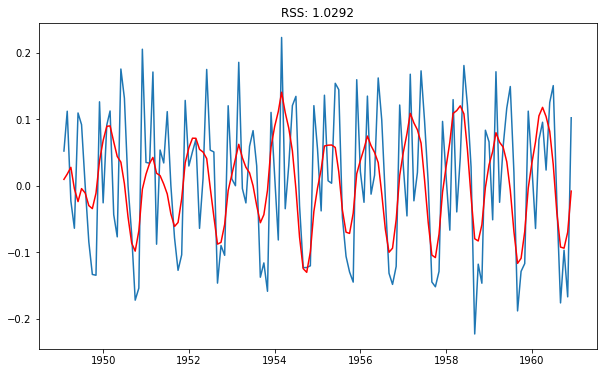

In [17]:
# ARIMA = AR + I + MA
ARIMA_model = ARIMA(data_logscale, order=(2,1,2))
results_ARIMA = ARIMA_model.fit(disp=-1)
plt.plot(data_log_shifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f' %sum((results_ARIMA.fittedvalues - data_log_shifting.Passengers)**2))
print('ARIMA Model')

RSS value in ARIMA is better than AR and MA models. We will do predictions on ARIMA model and also reconvert the predictions back to original form because we build our model on log transformed dataset.

# Predictions

In [18]:
Pred_ARIMA = pd.Series(results_ARIMA.fittedvalues, copy=True)
Pred_ARIMA.head()

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64

In [19]:
# Converting to cumulative sum
Pred_ARIMA_cumsum = Pred_ARIMA.cumsum()
Pred_ARIMA_cumsum

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
                ...   
1960-08-01    1.372552
1960-09-01    1.280202
1960-10-01    1.186189
1960-11-01    1.116265
1960-12-01    1.108138
Length: 143, dtype: float64

In [20]:
Pred_ARIMA_log = pd.Series(data_logscale.Passengers.iloc[0], index=data_logscale.index).add(Pred_ARIMA_cumsum, fill_value=0)
Pred_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

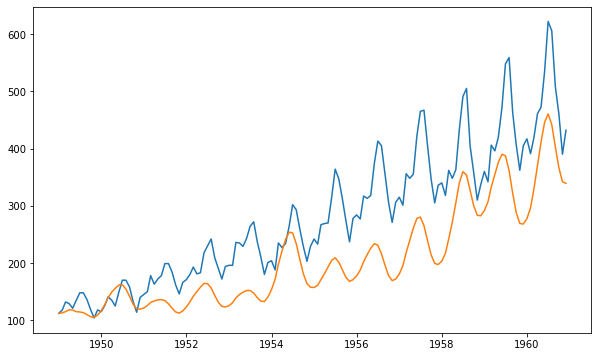

In [21]:
# inverse of log is exp
Pred_ARIMA = np.exp(Pred_ARIMA_log)
plt.plot(data)
plt.plot(Pred_ARIMA)

Predicted forecast are very close to real time values, indicated as a good model.

We have 144 ( existing data points of 12 years in months) and we want to forecast for additional 120 (data points for 10 years)

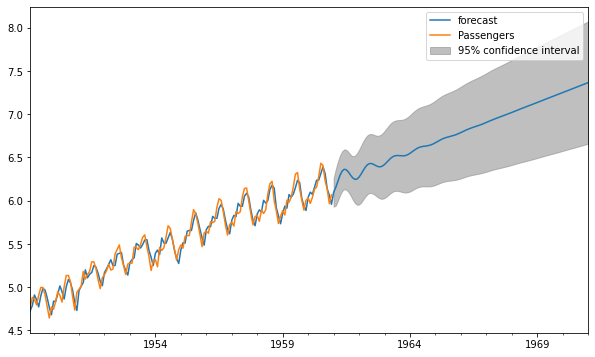

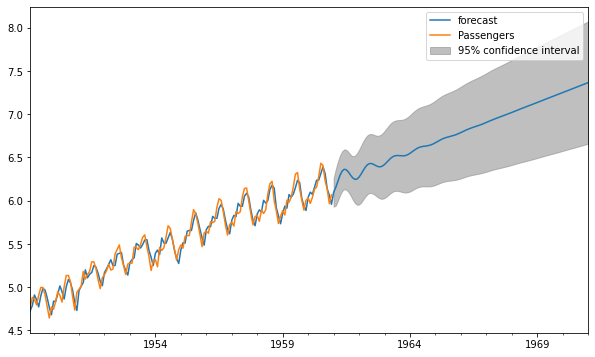

In [22]:
results_ARIMA.plot_predict(1,264)